
# Pump Performance Surrogate with PySMO Surrogate Object

In this demo, we will build a surrogate model of a reverse osmosis (RO) multispeed pump performance curve using the PySMO surrogate fitting tools. The surrogate will approximate the pump's power consumption $P$ and head $H$ as functions of flow rate, enabling rapid evaluations in system simulations and potential integration into optimization problems.

$$\begin{align*}
P &= f(Q)\\
H &= f(Q)
\end{align*}$$

We will then generate the multispeed pump power curve surrogate at different operating speeds $N$ and evaluate its accuracy against the original pump performance data.

$$P = f(Q, N)$$

In this demo you will learn:
- How to load pump performance data and prepare it for surrogate fitting
- How to build and evaluate surrogate models using PySMO
- How to visualize surrogate performance against original data
- How to save and load surrogate models for future use
<!-- - How to adaptively refine surrogate models based on error metrics
- How to compare different surrogate fitting strategies
- How to interpret surrogate error metrics and improve model accuracy
- How to integrate surrogate models into system simulations
- Best practices for surrogate modeling in water treatment applications -->

# Surrogate Modeling Workflow
The general workflow for building a surrogate model in WaterTAP involves the following steps:
1. **Load and preprocess the dataset for surrogate training and validation**
   1. Load data from CSV or other formats
   2. Sample input space or perform a training/validation split via PySMO sampling tools.
2. **Train the surrogate**
   1. Create a trainer object with specified input and output labels, training data, and surrogate type.
   2. Configure trainer options as needed
   3. Train the surrogate model
3. **Build Surrogate Object**
   1. Pass surrogate expressions, labels, and bounds to the chosen surrogate (Alamo, PySMO, Keras).
4. **Save the surrogate model for future use**
5. **Validate the surrogate**
   1. Evaluate surrogate performance using error metrics
   2. Visualize surrogate predictions against original data
6. **Load saved surrogate models as needed to your flowsheet**
7.  Optionally, adaptively **refine the surrogate** by adding samples based on error metrics

Don't fret! The following demo notebook will walk you through each of these steps in detail.
We get you covered with code snippets and explanations along the way.

<div style="background-color: #f9f9f9; border-left: 6px solid #4c78af; padding: 10px; margin: 10px 0;">
IDAES contains several surrogate modeling tools, including the <a href="https://idaes-pse.readthedocs.io/en/stable/explanations/modeling_extensions/surrogate/api/" style="color: #4c78af;">IDAES Surrogates API</a> which enables integrating ALAMO, PySMO or Keras surrogate models into IDAES flowsheets.

</div>

# Python-based Surrogate Modelling Objects (PySMO) introduction

<p align="center">
<img src="https://idaes-pse.readthedocs.io/en/stable/_images/pysmo-logo.png" width="300">
</p>

**Python-based Surrogate Modelling Objects** ([PySMO](https://idaes-pse.readthedocs.io/en/1.5.1/surrogate/pysmo/index.html)) provides tools for generating different types of reduced order models.

## Sampling with PySMO

The PySMO package offers five sampling methods:

* Latin Hypercube Sampling (LHS)
* Full-Factorial Sampling
* Halton Sampling
* Hammersley Sampling
* Centroidal voronoi tessellation (CVT) sampling

and two modes for data sampling:
- In `creation` mode, PySMO creates a specified number of sample points from the bounds provided by the user.
- In `selection` mode, PySMO selects a specified number of data points from a user-supplied dataset or file.

## Generating surrogates with PySMO

PySMO provides tools for generating three types of surrogates:

- Polynomial surrogates
- Radial basis function (RBF) surrogates, and
- Kriging surrogates

Details about the methods may be found in the [documentation](https://idaes-pse.readthedocs.io/en/stable/explanations/modeling_extensions/surrogate/api/pysmo/).

<div style="background-color: #f9f9f9; border-left: 6px solid #4c78af; padding: 10px; margin: 10px 0;"> In today's demo, we will focus on building polynomial surrogates using PySMO. </div>

# Import Libraries and Dataset

In [1]:
# Import necessary libraries
# Import statements
import os
import numpy as np
import pandas as pd

# Import Pyomo libraries
from pyomo.environ import (
    ConcreteModel,
    value,
    Var,
    Constraint,
    Set,
    Objective,
    units as pyunits,
)

# Import IDAES libraries
# Specific imports for surrogate modeling
from idaes.core.surrogate.sampling.data_utils import split_training_validation

# Import PySMO surrogate modeling tools
from idaes.core.surrogate.pysmo_surrogate import PysmoPolyTrainer, PysmoSurrogate

# Import plotting functions for surrogate evaluation
from idaes.core.surrogate.plotting.sm_plotter import (
    surrogate_scatter2D,
    surrogate_parity,
    surrogate_residual,
)

## Importing Training and Validation Datasets

In this section, we read the dataset from the CSV file and prepare it for surrogate training and validation. The data is separated using an <span style="background-color: #555; color: white;">80/20 split into training and validation data</span> using the IDAES `split_training_validation()` method.

<!-- For simplicity and to reduce training runtime, this example randomly selects <span style="background-color: #555; color: white;">100 data points</span> to use **for training/validation**.  -->

### Multispeed RO Pump Curve Data

The dataset includes pump head (ft) and power (HP) at various flow rates (GPM) for multiple pump speeds (RPM). We will focus on building surrogates for power consumption and head as a function of flow rate and head at a selected speed.

<p align="center">
<img src="pump_datasheet/multispeed-pump-curves.svg" width="700">
</p>

The pump performance data used in this demo is sourced from the following datasheet:

 [`week7/pump_datasheet/H10B26 DOCUMENTATION_related_to_RO_pump_multispeed_curves.pdf`](pump_datasheet/multispeed-ro-pump/H10B26%20DOCUMENTATION_related_to_RO_pump_multispeed_curves.pdf)

  *Operational note:* Flowrates below Minimum Continuous Stable Flow (MCSF) are excluded due to unstable pump operation / potential vibration or cavitation risk; analyses and model inputs should use ≥ MCSF datasets.

In [2]:
# Import Pump dataset

csv_path = os.path.join(
    "pump_datasheet", "multispeed-ro-pump_head_power_aligned_above_mcsf.csv"
)

csv_data = pd.read_csv(csv_path)  # load dataset, 408 data points

# Let's take a look at the first few rows of the dataset
full_data = csv_data
full_data.head()

,RPM,Flowrate_GPM,Head_ft,Power_HP,Flowrate_norm_global,Head_norm_global,Power_norm_global,Flowrate_norm_per_rpm,Head_norm_per_rpm,Power_norm_per_rpm,RPM_norm
0,1725,1.153790,193.534290,0.303061,0.076919,0.164107,0.009613,0.153838,0.937297,0.226591,0.5
1,1725,1.164629,193.458944,0.303303,0.077642,0.164004,0.009696,0.155284,0.936710,0.228545,0.5
2,1725,1.346094,192.169770,0.307348,0.089739,0.162246,0.011084,0.179479,0.926666,0.261262,0.5
3,1725,1.358724,192.080043,0.307619,0.090581,0.162123,0.011177,0.181163,0.925967,0.263454,0.5
4,1725,1.538399,190.756067,0.311475,0.102560,0.160317,0.012500,0.205119,0.915652,0.294635,0.5


In [3]:
# Filter relevant columns and order columns such as inputs followed by outputs
input_vars = ["Flowrate_norm_global", "RPM_norm"]
output_vars = ["Power_norm_global", "Head_norm_global"]
data = full_data[input_vars + output_vars]

data.head()

,Flowrate_norm_global,RPM_norm,Power_norm_global,Head_norm_global
0,0.076919,0.5,0.009613,0.164107
1,0.077642,0.5,0.009696,0.164004
2,0.089739,0.5,0.011084,0.162246
3,0.090581,0.5,0.011177,0.162123
4,0.102560,0.5,0.012500,0.160317


### Single Speed Surrogate Training and Validation Data Preparation

For single-speed pump surrogate modeling, we will fix the speed variable, reducing the model to:

$$\begin{align*}
P &= f(Q)\\
H &= f(Q)
\end{align*}$$

The input variable for the surrogate model in the dataset is:
- Normalized Flow Rate, $Q\rightarrow$ `Flowrate_norm_global`

The output variables are:
<div align="center">

|Input Variable|Symbol|Dataset Column|
|--------------|:------:|:--------------:|
|Normalized Power|$P$|`Power_norm_global`|
|Normalized Head|$H$|`Head_norm_global`|

</div>

We are going to filter the dataset for a single speed (e.g., `RPM_norm` = 1.0 which corresponds to 3450 RPM) before proceeding with surrogate training.

In [4]:
# Filter dataset for single-speed pump (e.g., RPM_norm = 1.0)
filtered_df = data[data["RPM_norm"] == 1.0]
data_single = filtered_df.reset_index(drop=True)
print(f"Single-speed pump dataset size: {data_single.shape}")
data_single.head()

Single-speed pump dataset size: (68, 4)


,Flowrate_norm_global,RPM_norm,Power_norm_global,Head_norm_global
0,0.153726,1.0,0.737452,0.956112
1,0.159390,1.0,0.740052,0.954500
2,0.179357,1.0,0.749217,0.948659
3,0.185948,1.0,0.752129,0.946732
4,0.204993,1.0,0.760545,0.940934


In [5]:
# Separate input and output data
input_data = data_single.loc[:, ["Flowrate_norm_global"]]
output_data = data_single.loc[:, ["Head_norm_global", "Power_norm_global"]]
# input_data = data_single.iloc[:, :1]  # first column is input
# output_data = data_single.iloc[:, ]  # second column and last column are outputs

# Define labels, and split training and validation data
# note that PySMO requires that labels are passed as string lists
input_labels = list(input_data.columns)
output_labels = list(output_data.columns)

n_data = data_single[input_labels[0]].size
# 80/20 train/validation split using IDAES utility function
data_single_training, data_single_validation = split_training_validation(
    data_single, 0.8, seed=n_data
)  # seed=n_data for reproducibility

print(f"Training data size: {data_single_training.shape}")
print(f"Validation data size: {data_single_validation.shape}")

data_single_training.head()

Training data size: (54, 4)
Validation data size: (14, 4)


c:\Users\Adam\.conda\envs\watertap-academy\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


,Flowrate_norm_global,RPM_norm,Power_norm_global,Head_norm_global
0,0.564330,1.0,0.859062,0.769359
1,0.185948,1.0,0.752129,0.946732
2,0.230634,1.0,0.771339,0.932880
3,0.554225,1.0,0.857719,0.776612
4,0.856238,1.0,0.896089,0.490311


# Train Surrogate with PySMO

In this section, we will build and train a polynomial surrogate model.
We will call and build the [Polynomial Regression class `PysmoPolyTrainer`](https://idaes-pse.readthedocs.io/en/stable/explanations/modeling_extensions/surrogate/api/pysmo/pysmo_polyregression.html) for this purpose.

`PysmoPolyTrainer` considers three types of basis functions:

- <span style="color:rgb(65, 105, 225)">univariate polynomials</span>,
- <span style="color:rgb(34, 139, 34)">second-degree bivariate polynomials</span>, and
- <span style="color:rgb(176, 48, 96)">user-specified basis functions</span>.

Then, for a problem with $m$ sample points and $n$ input variables, the resulting polynomial is:

\begin{equation*}
y_{k}={\displaystyle \textcolor{Royalblue}{\sum_{i=1}^{n}\beta_{i}x_{ik}^{\alpha}}+\textcolor{ForestGreen}{\sum_{i,j>i}^{n}\beta_{ij}x_{ik}x_{jk}}+\textcolor{Maroon}{\beta_{\Phi}\Phi\left(x_{ik}\right)}}\qquad i,j=1,\ldots,n;i\neq j;k=1,\ldots,m;\alpha \leq 10\qquad\quad
\end{equation*}

where:
- $y_{k}$ is the output variable,
- $x_{ik}$ is the $i^{th}$ input variable,
- $\textcolor{Royalblue}{\beta_{i}}$, $\textcolor{ForestGreen}{\beta_{ij}}$, and $\textcolor{Maroon}{\beta_{\Phi}}$ are the coefficients of the univariate, bivariate, and user-specified basis functions, respectively,
- $\alpha$ is the polynomial order of the univariate basis functions (up to a maximum of 10),
- $\textcolor{Maroon}{\Phi\left(x_{ik}\right)}$ is the user-specified basis function.

**PySMO Configuration Options:**

In this example, allowed basis terms span a 6<sup>th</sup> order polynomial as well as a variable product, and data is internally cross-validated using 10 iterations of 80/20 splits to ensure a robust surrogate fit. Note that PySMO uses cross-validation of training data to adjust model coefficients and ensure a more accurate fit, while we separate the validation dataset pre-training in order to visualize the surrogate fits.

|Parameter|Description|Value|
|---------|-----------|-----------|
|`maximum_polynomial_order`|Sets the maximum polynomial order for the surrogate model.|`6`|
|`multinomials`|Boolean option which determines whether bivariate terms are considered in polynomial generation.|`True`|
|`training_split`|Fraction of training data to be used for regression training.|`0.8`|
|`number_of_crossvalidations`|Number of cross-validation iterations to perform during training.|`10`|

In [6]:
# capture long output (not required to use surrogate API)
from io import StringIO
import sys

stream = StringIO()
oldstdout = sys.stdout
sys.stdout = stream

# Create PySMO trainer object
trainer = PysmoPolyTrainer(
    input_labels=input_labels,
    output_labels=output_labels,
    training_dataframe=data_single_training,
)

# Set PySMO options
trainer.config.maximum_polynomial_order = 4
trainer.config.multinomials = True
trainer.config.training_split = 0.8
trainer.config.number_of_crossvalidations = 10

# Train surrogate (calls PySMO through IDAES Python wrapper)
pysmo_surr_expr = trainer.train_surrogate()  # Surrogate expression object

# revert back to normal output capture
sys.stdout = oldstdout

# display first 50 lines and last 50 lines of output
celloutput = stream.getvalue().split("\n")
for line in celloutput[:50]:
    print(line)
print(".")
print(".")
print(".")
for line in celloutput[-50:]:
    print(line)

2026-01-23 12:19:20 [INFO] idaes.core.surrogate.pysmo_surrogate: Model for output Head_norm_global trained successfully
2026-01-23 12:19:28 [INFO] idaes.core.surrogate.pysmo_surrogate: Model for output Power_norm_global trained successfully

===========================Polynomial Regression===============================================


No iterations will be run.
Default parameter estimation method is used.
Parameter estimation method:  pyomo 

max_fraction_training_samples set at  0.5
Number of adaptive samples (no_adaptive_samples) set at  4
Maximum number of iterations (Max_iter) set at:  0

Initial surrogate model is of order 4  with a cross-val error of 0.000000
Initial Regression Model Performance:
Order:  4  / MAE: 0.000047  / MSE: 0.000000  / R^2: 1.000000  / Adjusted R^2: 1.000000

Polynomial regression generates a good surrogate model for the input data.

-------------------------------------------------
-------------------------------------------------
Best solution found: 

# Create Surrogate Object for Flowsheet Integration

We will now create a PySMO surrogate object using the trained surrogate model. This object can be integrated into an flowsheet for rapid evaluations of pump performance during simulations. The surrogate object will encapsulate the polynomial expressions and provide methods for predicting power consumption based on flow rate and head inputs. This allows for efficient incorporation of the surrogate model into larger system models, enabling optimization and analysis without the computational overhead of evaluating the original pump performance data.

To add the model to an IDAES flowsheet or generate model predictions, the `SurrogateTrainer` object needs to be transformed into an IDAES `SurrogateObject` object. This is done by calling `PySMOSurrogate` and passing the generated surrogate expressions, along with variable labels and optionally the bounds:

```python
surrogate = PysmoSurrogate(surrogate_exp, input_labels, output_labels, input_bounds)
```

In [7]:
%%capture

# Create callable surrogate object

# Set input bounds for surrogate
xmin = data_single_training[input_labels].min()
xmax = data_single_training[input_labels].max()

input_bounds = {input_labels[i]: (xmin[i], xmax[i]) for i in range(len(input_labels))}

# Call PysmoSurrogate to create surrogate object
pysmo_surr = PysmoSurrogate(pysmo_surr_expr, input_labels, output_labels, input_bounds)

## Save and Load PySMO Surrogate Model

Finally, after training the model we save the results and model expressions to a folder which contains a serialized JSON file. Serializing the model in this fashion enables importing a previously trained set of surrogate models into external flowsheets. This feature will be used later.

In [8]:
%%capture

# To save a model to JSON
model = pysmo_surr.save_to_file("pysmo_poly_surrogate.json", overwrite=True)

# To load a model
pysmo_surr = PysmoSurrogate.load_from_file("pysmo_poly_surrogate.json")

2026-01-23 12:19:28 [INFO] idaes.core.surrogate.pysmo_surrogate: Decode surrogate. type=poly


In [9]:
pysmo_surr_expr.display_pysmo_results()

Head_norm_global : 1.000188492794901 - 0.30760155684274815*IndexedParam[Flowrate_norm_global] + 0.28326659825825906*IndexedParam[Flowrate_norm_global]**2 - 1.0063313628225448*IndexedParam[Flowrate_norm_global]**3 + 0.33011492113227825*IndexedParam[Flowrate_norm_global]**4
Power_norm_global : 0.7181065928994205 - 0.1170593235825475*IndexedParam[Flowrate_norm_global] + 2.3315021720548716*IndexedParam[Flowrate_norm_global]**2 - 4.307561844650489*IndexedParam[Flowrate_norm_global]**3 + 2.3690972067879743*IndexedParam[Flowrate_norm_global]**4


# Visualize Surrogate Model

Once trained, surrogate models are visualized via scatter, parity, and residual plots to confirm their domain validity. Training data is plotted first to ensure the surrogates fit it correctly.

|Plot Type|Description|IDAES Function|
|---------|-----------|-----------|
|Scatter Plot|Visualizes surrogate predictions against actual data points in a 2D scatter format.|`surrogate_scatter2D`|
|Parity Plot|Compares surrogate predictions to actual data, ideally aligning along the y=x line.|`surrogate_parity`|
|Residual Plot|Shows the differences between surrogate predictions and actual data to identify patterns or biases.|`surrogate_residual`|

More details about visualization tools can be found in the [documentation](https://idaes-pse.readthedocs.io/en/stable/explanations/modeling_extensions/surrogate/plotting/index.html).

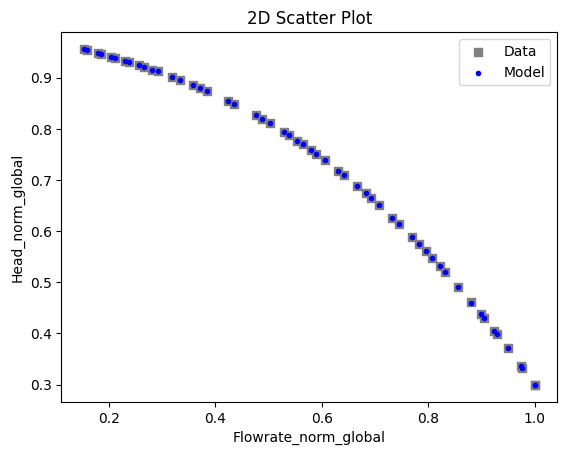

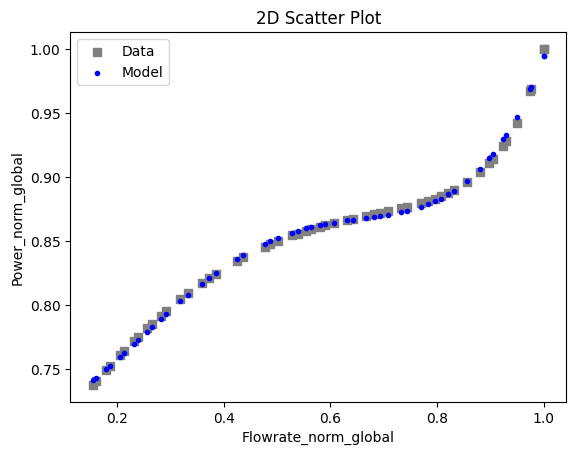

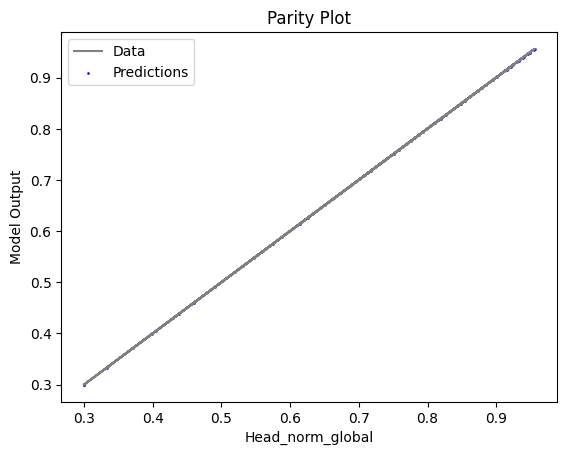

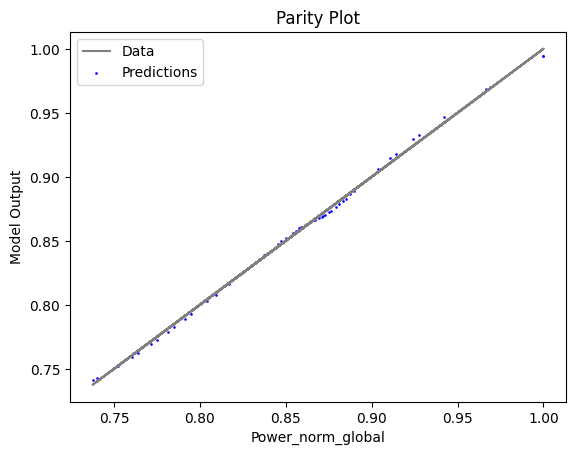

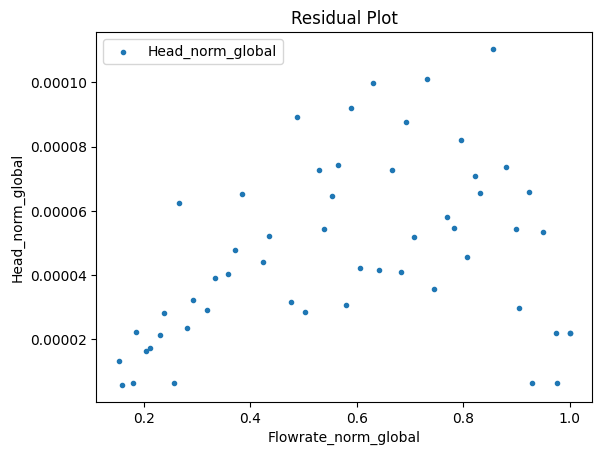

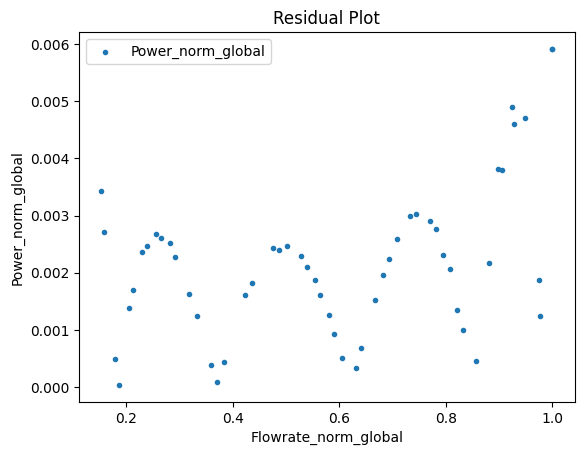

[<Figure size 640x480 with 1 Axes>, <Figure size 640x480 with 1 Axes>]

In [10]:
# visualize with IDAES surrogate plotting tools for training data
surrogate_scatter2D(
    pysmo_surr,
    data_single_training,
    filename="pysmo_poly_train_scatter2D.pdf",
    show=True,
)
surrogate_parity(
    pysmo_surr, data_single_training, filename="pysmo_poly_train_parity.pdf", show=True
)
surrogate_residual(
    pysmo_surr,
    data_single_training,
    filename="pysmo_poly_train_residual.pdf",
    show=True,
)

# Validate Surrogate Model

Now that we have trained the surrogate model, we can evaluate its performance on the validation dataset. This involves predicting the output values using the surrogate model and comparing them to the actual values in the validation set. We will compute error metrics such as Mean Absolute Error (MAE) and Mean Squared Error (MSE) to quantify the accuracy of the surrogate model. Additionally, we will visualize the surrogate predictions against the original data to assess how well the surrogate captures the underlying relationships.

## Visualize Surrogate with Validation Data

### 🛠️ Try It Yourself:

Let's visualize the surrogate model performance on the validation dataset using parity and residual plots. Use the IDAES plotting functions to create these visualizations and interpret the results.

<details>
  <summary><b>&#128161; Hint</b>: Visualize surrogate performance</summary>
    
To visualize the surrogate performance with the validation data, you can use the IDAES plotting functions like `surrogate_scatter2D`, `surrogate_parity`, and `surrogate_residual`.
We are only changing the dataset from training to validation in the function calls.
```python
# visualize with IDAES surrogate plotting tools for validation data
surrogate_scatter2D(
    pysmo_surr, data_single_validation, filename="pysmo_poly_val_scatter2D.pdf"
)
surrogate_parity(
    pysmo_surr, data_single_validation, filename="pysmo_poly_val_parity.pdf"
)
surrogate_residual(
    pysmo_surr, data_single_validation, filename="pysmo_poly_val_residual.pdf"
)
```
</details>

In [11]:
# visualize with IDAES surrogate plotting tools for validation data
# ...your code here...

## Surrogate fitting error metrics

The surrogate incorporates the following error metrics:

|Metric|Description|
|------|-----------|
|Mean Absolute Error (MAE)|Average absolute difference between surrogate predictions and actual values.|
|Mean Squared Error (MSE)|Average squared difference between surrogate predictions and actual values.|
|R-squared (R²)|Proportion of variance in the dependent variable predictable from the independent variables.|
|Adjusted R-squared (Adj. R²)|R² adjusted for the number of predictors in the model, providing a more accurate measure for multiple regression models.|

We can retrieve these metrics from the surrogate trainer object after validation.

In [12]:
# function to load surrogate JSON and display error metrics

import json
import pandas as pd


def display_surrogate_metrics(json_filepath):
    """
    Load surrogate JSON file and display error metrics in a formatted DataFrame.

    Parameters
    ----------
    json_filepath : str
        Path to the PySMO surrogate JSON file

    Returns
    -------
    pd.DataFrame
        DataFrame containing error metrics for each output variable
    """
    with open(json_filepath, "r") as f:
        data = json.load(f)

    metrics_list = []
    for output_var in data["model_encoding"]:
        metrics = data["model_encoding"][output_var]["attr"]["errors"]
        row = {"Output Variable": output_var}
        row.update(metrics)
        metrics_list.append(row)

    df_metrics = pd.DataFrame(metrics_list)

    # Format numeric columns
    numeric_cols = df_metrics.select_dtypes(include=[np.number]).columns
    df_metrics[numeric_cols] = df_metrics[numeric_cols].round(6)

    print("=" * 80)
    print(f"Surrogate Model Error Metrics: {json_filepath}")
    print("=" * 80)
    display(df_metrics)
    print("=" * 80)

    return df_metrics

In [13]:
# Display metrics for the trained surrogate
metrics_df = display_surrogate_metrics("pysmo_poly_surrogate.json")

Surrogate Model Error Metrics: pysmo_poly_surrogate.json


,Output Variable,MAE,MSE,R2,Adjusted R2
0,Head_norm_global,0.000047,0.000000,1.000000,1.000000
1,Power_norm_global,0.002164,0.000006,0.998338,0.998202


# Import Saved Surrogate Model into Flowsheet

Next, we will build the flowsheet and import the surrogate model object. Each output variable has a unique PySMO model expression, and the surrogate expressions may be added to the model via an indexed `Constraint()` component.

The code snippet below demonstrates how to import the saved surrogate model into an IDAES flowsheet and link it to the pump model variables. Add the surrogate to the IDAES `SurrogateBlock` as follows:

>```python
># Load the saved PySMO surrogate model
>surrogate = PysmoSurrogate.load_from_file("surrogate_expressions.json")
>m.fs.surrogate = SurrogateBlock()
># define inputs and outputs as lists of Pyomo Var objects
>m.fs.surrogate.build_model(surrogate, input_vars=inputs, output_vars=outputs)
>```

The surrogate automatically links flowsheet variables to model expressions by finding Pyomo variable objects for the model's inputs and outputs.

In [14]:
# Pyomo imports
from pyomo.environ import (
    ConcreteModel,
    check_optimal_termination,
    assert_optimal_termination,
    value,
)
from pyomo.environ import units as pyunits
from pyomo.util.calc_var_value import calculate_variable_from_constraint

# IDAES imports
from idaes.core import FlowsheetBlock
from idaes.core.util.model_statistics import degrees_of_freedom
from idaes.core.util.scaling import calculate_scaling_factors
import idaes.core.util.scaling as iscale
from idaes.core.util.constants import Constants as C

# Import SurrogateBlock for creating surrogate models
from idaes.core.surrogate.surrogate_block import SurrogateBlock

# WaterTAP imports
from watertap.core.solvers import get_solver
from watertap.property_models.seawater_prop_pack import SeawaterParameterBlock
from watertap.unit_models.pressure_changer import Pump

In [15]:
# Build pump model with PySMO surrogate
m = ConcreteModel()
m.fs = FlowsheetBlock(dynamic=False)

m.fs.props = SeawaterParameterBlock()

m.fs.pump = Pump(
    property_package=m.fs.props,
)

m.fs.pump.control_volume.properties_in[0].pressure.fix(101325)  # Pa
m.fs.pump.control_volume.properties_in[0].temperature.fix(298.15)  # K
m.fs.pump.control_volume.properties_in[0].flow_mass_phase_comp["Liq", "TDS"].fix(
    0.1
)  # kg/s
m.fs.pump.control_volume.properties_in[0].flow_vol_phase["Liq"].fix(
    10 * pyunits.gallon / pyunits.min
)
print("Degrees of freedom =", degrees_of_freedom(m))

Degrees of freedom = 2


In [16]:
# Define normalized input and output variables and constraints to link to actual pump model variables
Qmax = full_data["Flowrate_GPM"].max()
m.fs.normalized_flow_vol_in = Var(
    [0],
    initialize=0.5,
)
# Constraint to link normalized flow to actual pump flow
# 1 = Q_actual / Qmax_normalized
m.fs.eq_pump_flow = Constraint(
    expr=1
    == m.fs.pump.control_volume.properties_in[0].flow_vol_phase["Liq"]
    / pyunits.convert(
        m.fs.normalized_flow_vol_in[0] * Qmax * pyunits.gallon / pyunits.min,
        to_units=pyunits.m**3 / pyunits.s,
    )
)

Hmax = full_data["Head_ft"].max()
# Define normalized head variable and constraint
m.fs.normalized_head = Var(
    [0],
    initialize=0.5,
)

# Conversion constraint to link normalized head to actual pump head
# Head (m) = DeltaP / (rho * g)
m.fs.eq_pump_head = Constraint(
    expr=1
    == m.fs.pump.control_volume.deltaP[0]
    / (
        pyunits.convert(
            m.fs.normalized_head[0] * Hmax * pyunits.feet, to_units=pyunits.m
        )
        * m.fs.pump.control_volume.properties_in[0].dens_mass_phase["Liq"]
        * C.acceleration_gravity
    )
)

Pmax = full_data["Power_HP"].max()
m.fs.normalized_power_consumption = Var(
    [0],
    initialize=0.5,
)
# Conversion constraint to link normalized power to actual pump power
# Power (W) = Power_normalized * Pmax (hp) * 745.7 (W/hp) with
m.fs.eq_pump_power = Constraint(
    expr=1
    == m.fs.pump.work_mechanical[0]
    / pyunits.convert(
        m.fs.normalized_power_consumption[0] * Pmax * pyunits.hp, to_units=pyunits.W
    )
)

In [17]:
# create input and output variable object lists for flowsheet
inputs = [
    m.fs.normalized_flow_vol_in,
]
outputs = [
    m.fs.normalized_head,
    m.fs.normalized_power_consumption,
]

# create the Pyomo/IDAES block that corresponds to the surrogate

# load surrogate from JSON file
surrogate = PysmoSurrogate.load_from_file("pysmo_poly_surrogate.json")
# build surrogate block in flowsheet
m.fs.surrogate = SurrogateBlock(concrete=True)
# build surrogate model in block
m.fs.surrogate.build_model(surrogate, input_vars=inputs, output_vars=outputs)

2026-01-23 12:19:29 [INFO] idaes.core.surrogate.pysmo_surrogate: Decode surrogate. type=poly

===========================Polynomial Regression===============================================


The number of cross-validation cases (3) is used.
The default training/cross-validation split of 0.75 is used.
No iterations will be run.
Default parameter estimation method is used.
Parameter estimation method:  pyomo 


===========================Polynomial Regression===============================================


The number of cross-validation cases (3) is used.
The default training/cross-validation split of 0.75 is used.
No iterations will be run.
Default parameter estimation method is used.
Parameter estimation method:  pyomo 



In [18]:
# Solve flowsheet

# Calculate surrogate outputs based on fixed inputs to initialize the surrogates
calculate_variable_from_constraint(
    m.fs.normalized_power_consumption[0],
    m.fs.surrogate.pysmo_constraint["Power_norm_global"],
)
calculate_variable_from_constraint(
    m.fs.normalized_head[0], m.fs.surrogate.pysmo_constraint["Head_norm_global"]
)
# Calculate scaling factors
iscale.calculate_scaling_factors(m)
# m.fs.pump.initialize()

# Check degrees of freedom
print("DOF=", degrees_of_freedom(m))

# Solve the model
solver = get_solver()
solver.solve(m.fs.pump.control_volume.properties_in[0], tee=True)
results = solver.solve(m, tee=True)

# Check for optimal termination
assert_optimal_termination(results)

2026-01-23 12:19:29 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.pump.control_volume.properties_in[0.0].flow_mass_phase_comp[Liq,H2O]
2026-01-23 12:19:29 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.pump.control_volume.properties_in[0.0].flow_mass_phase_comp[Liq,TDS]
2026-01-23 12:19:29 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.pump.control_volume.properties_out[0.0].flow_mass_phase_comp[Liq,H2O]
2026-01-23 12:19:29 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.pump.control_volume.properties_out[0.0].flow_mass_phase_comp[Liq,TDS]
2026-01-23 12:19:29 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.pump.control_volume.work
DOF= 0
ipopt-watertap: ipopt with user variable scaling and IDAES jacobian constraint scaling
Ipopt 3.13.2: tol=1e-08
constr_viol_tol=1e-08
acceptable_constr_viol_tol=1e-08
bound_relax_factor=0.0
honor_original_bounds=no
nlp_scaling_method=user-scaling


*****************

In [19]:
m.fs.surrogate.pprint()

surrogate : Size=1, Index=None, Active=True
    1 Constraint Declarations
        pysmo_constraint : Size=2, Index={Head_norm_global, Power_norm_global}, Active=True
            Key               : Lower : Body                                                                                                                                                                                                                                                                      : Upper : Active
             Head_norm_global :   0.0 :           fs.normalized_head[0] - (1.000188492794901 - 0.30760155684274815*fs.normalized_flow_vol_in[0] + 0.28326659825825906*fs.normalized_flow_vol_in[0]**2 - 1.0063313628225448*fs.normalized_flow_vol_in[0]**3 + 0.33011492113227825*fs.normalized_flow_vol_in[0]**4) :   0.0 :   True
            Power_norm_global :   0.0 : fs.normalized_power_consumption[0] - (0.7181065928994205 - 0.1170593235825475*fs.normalized_flow_vol_in[0] + 2.3315021720548716*fs.normalized_flow_v

In [20]:
m.fs.pump.report()


Unit : fs.pump                                                             Time: 0.0
------------------------------------------------------------------------------------
    Unit Performance

    Variables: 

    Key             : Value      : Units                               : Fixed : Bounds
         Efficiency :    0.53821 :                       dimensionless : False : (None, None)
    Mechanical Work :     2064.3 : kilogram * meter ** 2 / second ** 3 : False : (None, None)
    Pressure Change : 1.7611e+06 :                              pascal : False : (None, None)
     Pressure Ratio :     18.380 :                       dimensionless : False : (None, None)

------------------------------------------------------------------------------------
    Stream Table
                                              Units           Inlet     Outlet  
    flow_mass_phase_comp ('Liq', 'H2O')  kilogram / second    0.59783    0.59783
    flow_mass_phase_comp ('Liq', 'TDS')  kilogram / second   

## Conduct Parameter Sweep Analysis (covered in [Session 5](../week5/parameter_sweep_demo.ipynb))

### Sweep across pump flowrate and solve the model for each flowrate point

In [21]:
from parameter_sweep import LinearSample, parameter_sweep

sweep_params = {}
# Define the parameter sweep for the pump flow rate
sweep_params["Flowrate"] = LinearSample(
    m.fs.pump.control_volume.properties_in[0].flow_vol_phase,
    value(
        pyunits.convert(
            5 * pyunits.gallon / pyunits.min, to_units=pyunits.m**3 / pyunits.s
        )
    ),
    value(
        pyunits.convert(
            15 * pyunits.gallon / pyunits.min, to_units=pyunits.m**3 / pyunits.s
        )
    ),
    11,
)
outputs = {}
outputs["Efficiency"] = m.fs.pump.efficiency_pump[0]
outputs["Power Consumption_W"] = m.fs.pump.work_mechanical[0]
outputs["Pressure"] = m.fs.pump.deltaP[0]

# Perform the parameter sweep
file_save = "pump_surrogate_sensitivity.csv"

results_array, results_dict = parameter_sweep(
    build_model=m,
    build_sweep_params=sweep_params,
    build_outputs=outputs,
    csv_results_file_name=file_save,
)

is deprecated                                 and will not work with future
implementations of parallelism.  (deprecated in 0.10.0) (called from
c:\Users\Adam\.conda\envs\watertap-academy\Lib\site-
packages\parameter_sweep\functions.py:170)
function is deprecated                                 and will not work with
future implementations of parallelism.  (deprecated in 0.10.0) (called from
c:\Users\Adam\.conda\envs\watertap-academy\Lib\site-
packages\parameter_sweep\functions.py:170)
function is deprecated                                 and will not work with
future implementations of parallelism.  (deprecated in 0.10.0) (called from
c:\Users\Adam\.conda\envs\watertap-academy\Lib\site-
packages\parameter_sweep\functions.py:170)


## Plot hybrid pump model results

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the results
df = pd.read_csv(file_save)
df

,# Flowrate,Efficiency,Power Consumption_W,Pressure
0,0.000315,0.407914,1921.415,2484607.0
1,0.000379,0.449884,1972.401,2344135.0
2,0.000442,0.484734,2011.702,2208042.0
3,0.000505,0.512155,2038.467,2068489.0
4,0.000568,0.530791,2054.517,1920563.0
5,0.000631,0.538213,2064.345,1761063.0
6,0.000694,0.531057,2075.113,1587918.0
7,0.000757,0.505485,2096.657,1399885.0
8,0.000820,0.458204,2141.481,1196375.0
9,0.000883,0.388025,2224.763,977357.9


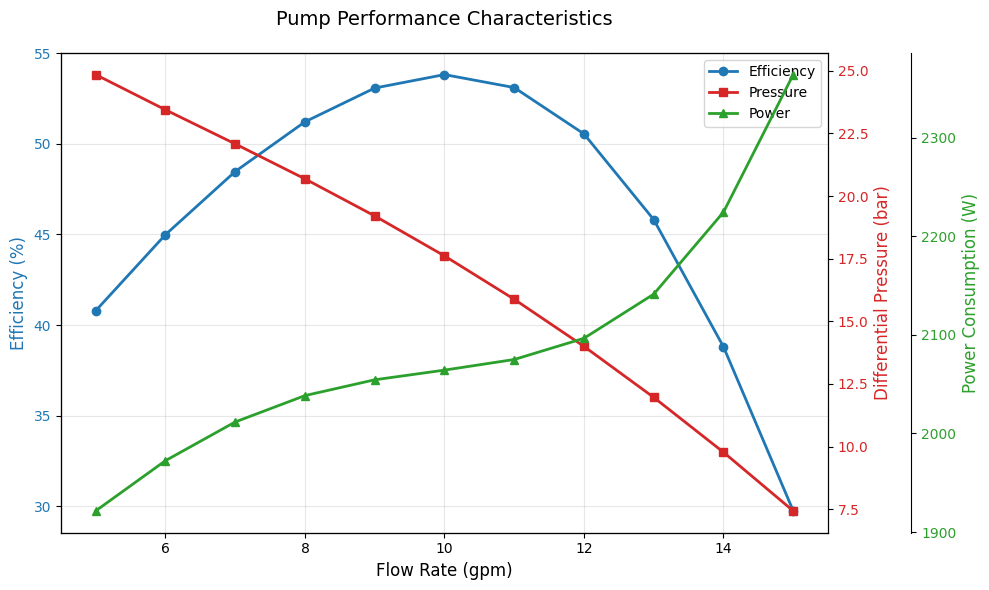


=== Pump Performance Summary ===
Flow range: 5.0 - 15.0 gpm
Efficiency range: 29.8 - 53.8 %
Pressure range: 7.43 - 24.85 bar
Power range: 1921.4 - 2364.3 W

Optimal efficiency: 53.8% at 10.0 gpm


In [23]:
# Convert flow rate back to gpm for easier interpretation
df["Flowrate_gpm"] = df["# Flowrate"] * 15850.323  # m3/s to gal/min

# Create figure with multiple y-axes
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot 1: Efficiency (left y-axis)
color1 = "tab:blue"
ax1.set_xlabel("Flow Rate (gpm)", fontsize=12)
ax1.set_ylabel("Efficiency (%)", color=color1, fontsize=12)
line1 = ax1.plot(
    df["Flowrate_gpm"],
    df["Efficiency"] * 100,
    "o-",
    color=color1,
    linewidth=2,
    markersize=6,
    label="Efficiency",
)
ax1.tick_params(axis="y", labelcolor=color1)
ax1.grid(True, alpha=0.3)

# Plot 2: Pressure (right y-axis 1)
ax2 = ax1.twinx()
color2 = "tab:red"
ax2.set_ylabel("Differential Pressure (bar)", color=color2, fontsize=12)
line2 = ax2.plot(
    df["Flowrate_gpm"],
    df["Pressure"] / 1e5,
    "s-",
    color=color2,
    linewidth=2,
    markersize=6,
    label="Pressure",
)
ax2.tick_params(axis="y", labelcolor=color2)

# Plot 3: Power (right y-axis 2)
ax3 = ax1.twinx()
# Offset the right spine of ax3
ax3.spines["right"].set_position(("outward", 60))
color3 = "tab:green"
ax3.set_ylabel("Power Consumption (W)", color=color3, fontsize=12)
line3 = ax3.plot(
    df["Flowrate_gpm"],
    df["Power Consumption_W"],
    "^-",
    color=color3,
    linewidth=2,
    markersize=6,
    label="Power",
)
ax3.tick_params(axis="y", labelcolor=color3)

# Add title
plt.title("Pump Performance Characteristics", fontsize=14, pad=20)

# Combine legends
lines = line1 + line2 + line3
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc="best", fontsize=10)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n=== Pump Performance Summary ===")
print(
    f"Flow range: {df['Flowrate_gpm'].min():.1f} - {df['Flowrate_gpm'].max():.1f} gpm"
)
print(
    f"Efficiency range: {df['Efficiency'].min()*100:.1f} - {df['Efficiency'].max()*100:.1f} %"
)
print(
    f"Pressure range: {df['Pressure'].min()/1e5:.2f} - {df['Pressure'].max()/1e5:.2f} bar"
)
print(
    f"Power range: {df['Power Consumption_W'].min():.1f} - {df['Power Consumption_W'].max():.1f} W"
)
print(
    f"\nOptimal efficiency: {df['Efficiency'].max()*100:.1f}% at {df.loc[df['Efficiency'].idxmax(), 'Flowrate_gpm']:.1f} gpm"
)

# 🛠️**Your Turn!**
It is your turn now! Try building surrogates for other pump speeds using the provided dataset and evaluate their performance. Experiment with different polynomial orders and basis function configurations to see how they affect the surrogate accuracy.

## **Try it yourself #1:** Build a surrogate model for another speed.

Select a different speed from the dataset (e.g., `RPM_norm` = 0.8 which corresponds to 2760 RPM) and filter the dataset accordingly. Then, proceed with surrogate training, validation, and visualization as demonstrated earlier.

### Prepare the data for training and validation

<details>
  <summary><b>&#128161;Hint #1</b>: Filter the dataset for a specific speed</summary>
    
To filter the dataset for a specific speed, you can use the following code snippet:
```python
# Filter dataset for a specific speed (e.g., RPM_norm = 0.8)
speed_value = 0.8
data_speed = data[data['RPM_norm'] == speed_value]
```
</details>

In [24]:
# Filter dataset for a specific speed (e.g., RPM_norm = 0.8)

# speed_value = ... your code here ...
# data_speed = ... your code here ...
# Uncomment and complete the code below
# data_speed = data_speed.reset_index(drop=True)
# print(f"Dataset size for RPM_norm = {speed_value}: {data_speed.shape}")
# data_speed.head()

In [25]:
# Filter dataset for a specific speed (e.g., RPM_norm = 0.8)
speed_value = 0.8
data_speed = data[data["RPM_norm"] == speed_value]

data_speed = data_speed.reset_index(drop=True)
print(f"Dataset size for RPM_norm = {speed_value}: {data_speed.shape}")
data_speed.head()

Dataset size for RPM_norm = 0.8: (68, 4)


,Flowrate_norm_global,RPM_norm,Power_norm_global,Head_norm_global
0,0.123037,0.8,0.331539,0.575942
1,0.125964,0.8,0.332399,0.575275
2,0.143547,0.8,0.337564,0.571178
3,0.146955,0.8,0.338527,0.570384
4,0.164058,0.8,0.343363,0.566232


<details>
  <summary><b>&#128161;Hint #2</b>: Define input/output data and labels, and split data into training and validation datasets</summary>
    
To filter the dataset for a specific speed, you can use the following code snippet:
```python
# Separate input and output data
input_data = data_speed.loc[:, ['Flowrate_norm_global']]
output_data = data_speed.loc[:,["Head_norm_global","Power_norm_global"]]

# Define labels, and split training and validation data
# note that PySMO requires that labels are passed as string lists
input_labels = list(input_data.columns)
output_labels = list(output_data.columns)

# Number of data points to use for seed
n_data = data_speed[input_labels[0]].size
# 80/20 train/validation split using IDAES utility function
data_speed_training, data_speed_validation = split_training_validation(
    data_speed, 0.8, seed=n_data
)
```
</details>

In [26]:
# Separate input and output data
# input_data = ... your code here ...
# output_data = ... your code here ... # last column is output

# Define labels, and split training and validation data
# note that PySMO requires that labels are passed as string lists
# input_labels = ... your code here ...
# output_labels = ...your code here ...

# Number of data points to use for seed
# n_data = ... your code here ...
# 80/20 train/validation split using IDAES utility function
# data_speed_training, data_speed_validation = ...your code here ...

# Uncomment the code below once above lines are completed
# print(f"Training data size: {data_speed_training.shape}")
# print(f"Validation data size: {data_speed_validation.shape}")

# data_speed_training.head()

In [27]:
# Separate input and output data
input_data = data_speed.loc[:, ["Flowrate_norm_global"]]
output_data = data_speed.loc[:, ["Head_norm_global", "Power_norm_global"]]

# Define labels, and split training and validation data
# note that PySMO requires that labels are passed as string lists
input_labels = list(input_data.columns)
output_labels = list(output_data.columns)

n_data = data_speed[input_labels[0]].size
# 80/20 train/validation split using IDAES utility function
data_speed_training, data_speed_validation = split_training_validation(
    data_speed, 0.8, seed=n_data
)  # seed=n_data for reproducibility

print(f"Training data size: {data_speed_training.shape}")
print(f"Validation data size: {data_speed_validation.shape}")

data_speed_training.head()

Training data size: (54, 4)
Validation data size: (14, 4)


c:\Users\Adam\.conda\envs\watertap-academy\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


,Flowrate_norm_global,RPM_norm,Power_norm_global,Head_norm_global
0,0.451356,0.8,0.393778,0.456504
1,0.146955,0.8,0.338527,0.570384
2,0.184571,0.8,0.348889,0.561074
3,0.439073,0.8,0.392733,0.463464
4,0.682366,0.8,0.412258,0.280341


### Train the surrogate model

Now you can proceed to create and train a new surrogate model for this specific speed using the same steps as before.

**PySMO Configuration Options:**

|Parameter|Description|Value|
|---------|-----------|-----------|
|`maximum_polynomial_order`|Sets the maximum polynomial order for the surrogate model.|`6`|
|`multinomials`|Boolean option which determines whether bivariate terms are considered in polynomial generation.|`True`|
|`training_split`|Fraction of training data to be used for regression training.|`0.8`|
|`number_of_crossvalidations`|Number of cross-validation iterations to perform during training.|`10`|

<details>
  <summary><b>&#128161;Hint #3</b>: Create, configure, and train a PySMO trainer object</summary>
    
To create a PySMO trainer object with the specified configuration options, you can use the following code snippet:
```python
# Create PySMO trainer object
trainer = PysmoPolyTrainer(
    input_labels=input_labels,
    output_labels=output_labels,
    training_dataframe=data_speed_training,
)

# Set PySMO options
trainer.config.maximum_polynomial_order = 6
trainer.config.multinomials = True
trainer.config.training_split = 0.8
trainer.config.number_of_crossvalidations = 10

# Train surrogate (calls PySMO through IDAES Python wrapper)
pysmo_surr_expr = trainer.train_surrogate()  # Surrogate expression object
```
</details>

In [28]:
# capture long output (not required to use surrogate API)
from io import StringIO
import sys

stream = StringIO()
oldstdout = sys.stdout
sys.stdout = stream

# Create PySMO trainer object
# trainer = PysmoPolyTrainer(
# ...your code here ...
# )

# Set PySMO options
# trainer.config.option = ...value...
# ...your code here ...

# Train surrogate (calls PySMO through IDAES Python wrapper)
# pysmo_surr_expr = ...your code here ...

# revert back to normal output capture
sys.stdout = oldstdout

# display first 50 lines and last 50 lines of output
celloutput = stream.getvalue().split("\n")
for line in celloutput[:50]:
    print(line)
print(".")
print(".")
print(".")
for line in celloutput[-50:]:
    print(line)


.
.
.



In [29]:
# capture long output (not required to use surrogate API)
from io import StringIO
import sys

stream = StringIO()
oldstdout = sys.stdout
sys.stdout = stream

# Create PySMO trainer object
trainer = PysmoPolyTrainer(
    input_labels=input_labels,
    output_labels=output_labels,
    training_dataframe=data_speed_training,
)

# Set PySMO options
trainer.config.maximum_polynomial_order = 6
trainer.config.multinomials = True
trainer.config.training_split = 0.8
trainer.config.number_of_crossvalidations = 10

# Train surrogate (calls PySMO through IDAES Python wrapper)
pysmo_surr_expr = trainer.train_surrogate()  # Surrogate expression object

# revert back to normal output capture
sys.stdout = oldstdout

# display first 50 lines and last 50 lines of output
celloutput = stream.getvalue().split("\n")
for line in celloutput[:50]:
    print(line)
print(".")
print(".")
print(".")
for line in celloutput[-50:]:
    print(line)

2026-01-23 12:19:44 [INFO] idaes.core.surrogate.pysmo_surrogate: Model for output Head_norm_global trained successfully
2026-01-23 12:19:56 [INFO] idaes.core.surrogate.pysmo_surrogate: Model for output Power_norm_global trained successfully

===========================Polynomial Regression===============================================


No iterations will be run.
Default parameter estimation method is used.
Parameter estimation method:  pyomo 

max_fraction_training_samples set at  0.5
Number of adaptive samples (no_adaptive_samples) set at  4
Maximum number of iterations (Max_iter) set at:  0

Initial surrogate model is of order 4  with a cross-val error of 0.000000
Initial Regression Model Performance:
Order:  4  / MAE: 0.000027  / MSE: 0.000000  / R^2: 1.000000  / Adjusted R^2: 1.000000

Polynomial regression generates a good surrogate model for the input data.

-------------------------------------------------
-------------------------------------------------
Best solution found: 

### Create Surrogate Object for Flowsheet Integration

Remember that the `PysmoSurrogate` class requires the surrogate expressions, input/output labels, and input bounds to create the surrogate object.

<details>
  <summary><b>&#128161;Hint #4</b>: Create a PySMO Surrogate Object</summary>
    
To create a PySMO surrogate object with the trained surrogate expressions, you can use the following code snippet:
```python
# Set input bounds for surrogate
xmin = data_speed_training[input_labels].min()
xmax = data_speed_training[input_labels].max()

input_bounds = {input_labels[i]: (xmin[i], xmax[i]) for i in range(len(input_labels))}

# Call PysmoSurrogate to create surrogate object
poly_surr = PysmoSurrogate(pysmo_surr_expr, input_labels, output_labels, input_bounds)
```
</details>

In [30]:
%%capture
# Create callable surrogate object

# Set input bounds for surrogate
# xmin = ...your code here...
# xmax = ...your code here...

# input_bounds = ...your code here...

# Call PysmoSurrogate to create surrogate object
# poly_surr = ...your code here...

In [31]:
%%capture
# Create callable surrogate object

# Set input bounds for surrogate
xmin = data_speed_training[input_labels].min()
xmax = data_speed_training[input_labels].max()

input_bounds = {input_labels[i]: (xmin[i], xmax[i]) for i in range(len(input_labels))}

# Call PysmoSurrogate to create surrogate object
poly_surr = PysmoSurrogate(pysmo_surr_expr, input_labels, output_labels, input_bounds)

### Save Surrogate Model

Save the PySMO surrogate model to JSON as `"pysmo_poly_surrogate_speed0_8.json"`.

<details>
  <summary><b>&#128161;Hint #5</b>: Save the PySMO Surrogate Object for Later Use</summary>
    
To save the PySMO surrogate object for later use, you can use the following code snippet:
```python
# To save a model to JSON
model = poly_surr.save_to_file("pysmo_poly_surrogate_speed0_8.json", overwrite=True)
```
</details>

In [32]:
# Save the PySMO surrogate model to JSON
# ...your code here...

In [33]:
# Save the PySMO surrogate model to JSON
model = poly_surr.save_to_file("pysmo_poly_surrogate_speed0_8.json", overwrite=True)

### Validate Surrogate Model

Using the validation dataset, evaluate the surrogate model performance calling the `display_surrogate_metrics` function.

<details>
  <summary><b>&#128161;Hint #6</b>: Validate the Surrogate Model</summary>

To validate the surrogate model using the validation dataset, you can use the following code snippet:

```python
# Display metrics for the trained surrogate
metrics_df1 = display_surrogate_metrics("pysmo_poly_surrogate_speed0_8.json")
```
</details>

In [34]:
# Display metrics for the trained surrogate
# metrics_df1 = ...your code here...

In [35]:
# Display metrics for the trained surrogate
metrics_df1 = display_surrogate_metrics("pysmo_poly_surrogate_speed0_8.json")

Surrogate Model Error Metrics: pysmo_poly_surrogate_speed0_8.json


,Output Variable,MAE,MSE,R2,Adjusted R2
0,Head_norm_global,0.000027,0.0,1.000000,1.000000
1,Power_norm_global,0.000190,0.0,0.999951,0.999944


# Build a surrogate model for all the speeds.

Build a surrogate model for all the speeds. Follow the same steps as in the demo to train and validate the surrogate model.

**Multispeed Pump Surrogate Input and Output Variables**

We are going to use the normalized values of the input and output variables for surrogate training and validation.

$$P = f(Q, H)$$

The input variables for the surrogate model in the dataset are:

<div align="center">

|Input Variable|Symbol|Dataset Column|
|--------------|------|--------------|
|Flow rate|$Q$|`Flowrate_norm_global`|
|Head|$H$|`Head_norm_global`|

</div>

The output variable is:
- Power, $P\rightarrow$ `Power_norm_global`

In [36]:
# For the multi-speed pump dataset
# Set numpy print options for better readability
np.set_printoptions(precision=6, suppress=True)

In [37]:
# Separate input and output data
input_data = data.loc[:, ["Flowrate_norm_global", "Head_norm_global"]]  
output_data = data.loc[:, "Power_norm_global"]  # last column is output

# Define labels, and split training and validation data
# note that PySMO requires that labels are passed as string lists
input_labels = list(input_data.columns)
output_labels = [output_data.name]

n_data = data[input_labels[0]].size
# 80/20 train/validation split using IDAES utility function
data_training, data_validation = split_training_validation(
    data, 0.8, seed=n_data
)  # seed=n_data for reproducibility
data_training.head()
print(f"Training data size: {data_training.shape}")
print(f"Validation data size: {data_validation.shape}")

Training data size: (326, 4)
Validation data size: (82, 4)


c:\Users\Adam\.conda\envs\watertap-academy\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [38]:
data

,Flowrate_norm_global,RPM_norm,Power_norm_global,Head_norm_global
0,0.076919,0.5,0.009613,0.164107
1,0.077642,0.5,0.009696,0.164004
2,0.089739,0.5,0.011084,0.162246
3,0.090581,0.5,0.011177,0.162123
4,0.102560,0.5,0.012500,0.160317
...,...,...,...,...
403,0.952617,1.0,0.945446,0.366123
404,0.974782,1.0,0.966708,0.335434
405,0.976374,1.0,0.968810,0.333230
406,0.999997,1.0,1.000000,0.299663


In [39]:
# capture long output (not required to use surrogate API)
from io import StringIO
import sys

stream = StringIO()
oldstdout = sys.stdout
sys.stdout = stream

# Create PySMO trainer object
trainer = PysmoPolyTrainer(
    input_labels=input_labels,
    output_labels=output_labels,
    training_dataframe=data_training,
)

# Set PySMO options
trainer.config.maximum_polynomial_order = 6
trainer.config.multinomials = True
trainer.config.training_split = 0.8
trainer.config.number_of_crossvalidations = 10

# Train surrogate (calls PySMO through IDAES Python wrapper)
poly_train = trainer.train_surrogate()  # Surrogate expression object

# Create callable surrogate object

# Set input bounds for surrogate
xmin = data_training[input_labels].min()
xmax = data_training[input_labels].max()

input_bounds = {input_labels[i]: (xmin[i], xmax[i]) for i in range(len(input_labels))}

# Call PysmoSurrogate to create surrogate object
poly_surr = PysmoSurrogate(poly_train, input_labels, output_labels, input_bounds)

# save model to JSON
model = poly_surr.save_to_file("pysmo_poly_surrogate_multispeed.json", overwrite=True)

# revert back to normal output capture
sys.stdout = oldstdout

# display first 50 lines and last 50 lines of output
celloutput = stream.getvalue().split("\n")
for line in celloutput[:50]:
    print(line)
print(".")
print(".")
print(".")
for line in celloutput[-50:]:
    print(line)

2026-01-23 12:20:10 [INFO] idaes.core.surrogate.pysmo_surrogate: Model for output Power_norm_global trained successfully

===========================Polynomial Regression===============================================


No iterations will be run.
Default parameter estimation method is used.
Parameter estimation method:  pyomo 

max_fraction_training_samples set at  0.5
Number of adaptive samples (no_adaptive_samples) set at  4
Maximum number of iterations (Max_iter) set at:  0

Initial surrogate model is of order 5  with a cross-val error of 0.000011
Initial Regression Model Performance:
Order:  5  / MAE: 0.003345  / MSE: 0.000022  / R^2: 0.999739  / Adjusted R^2: 0.999730

Polynomial regression generates a good surrogate model for the input data.

-------------------------------------------------
-------------------------------------------------
Best solution found:  
Order:  5  / MAE: 0.003345  / MSE: 0.000022  / R_sq: 0.999739  / Adjusted R^2: 0.999730

-----------------------------

C:\Users\Adam\AppData\Local\Temp\ipykernel_98340\1605474871.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  input_bounds = {input_labels[i]: (xmin[i], xmax[i]) for i in range(len(input_labels))}


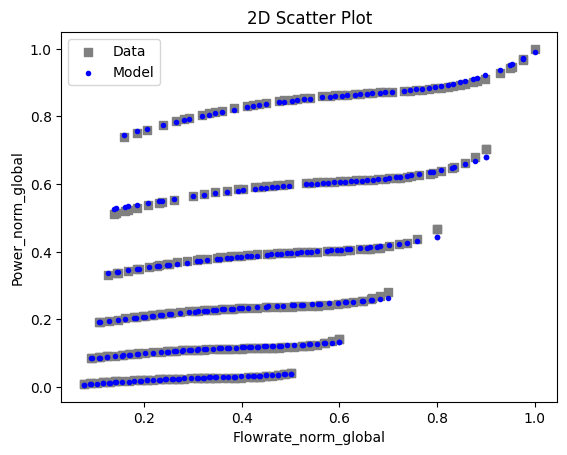

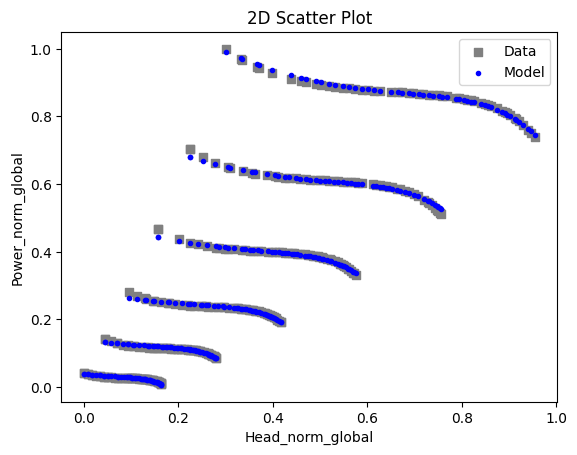

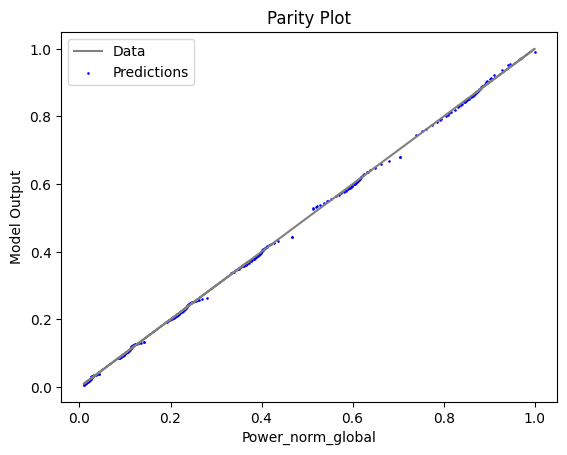

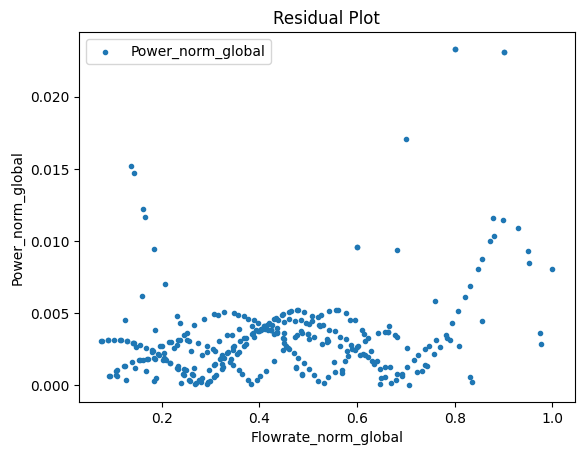

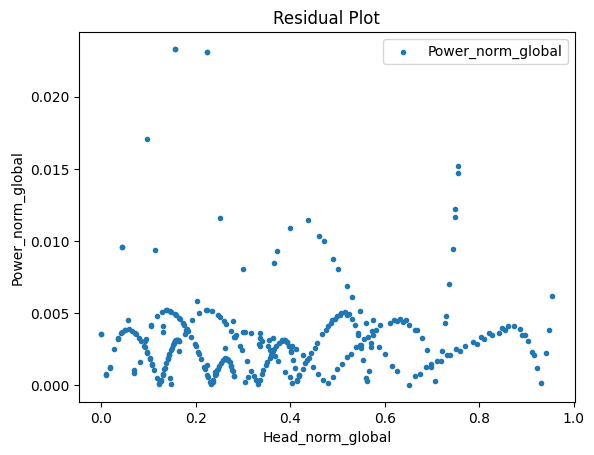

[<Figure size 640x480 with 1 Axes>, <Figure size 640x480 with 1 Axes>]

In [40]:
# visualize with IDAES surrogate plotting tools for validation data
surrogate_scatter2D(
    poly_surr, data_training, filename="pysmo_poly_val_multispeed_catter2D.pdf"
)
surrogate_parity(
    poly_surr, data_training, filename="pysmo_poly_val_multispeedparity.pdf"
)
surrogate_residual(
    poly_surr, data_training, filename="pysmo_poly_val_multispeedresidual.pdf"
)

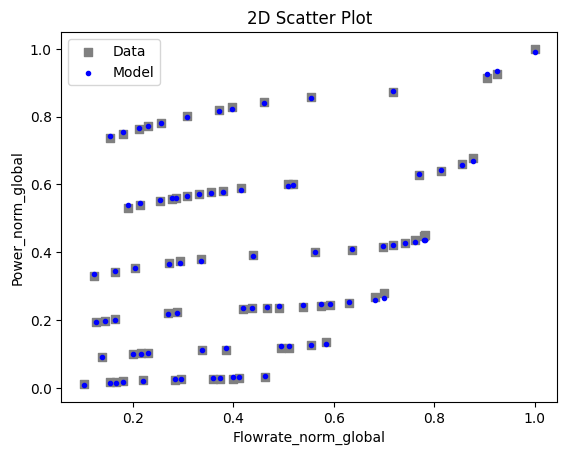

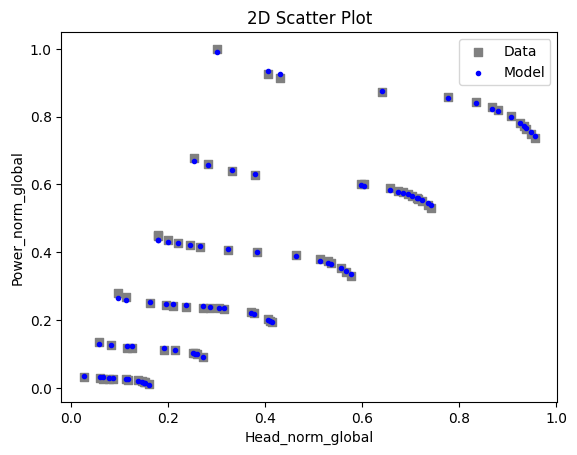

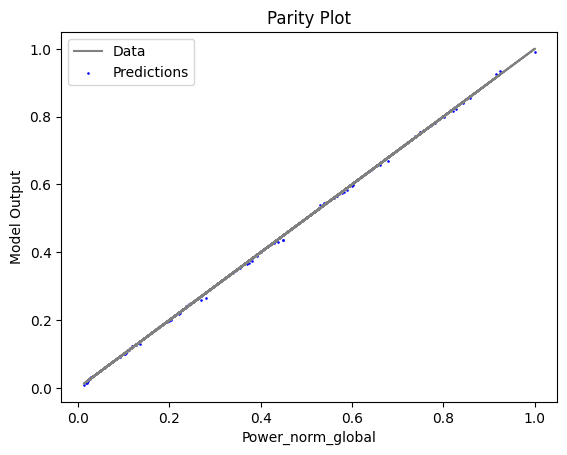

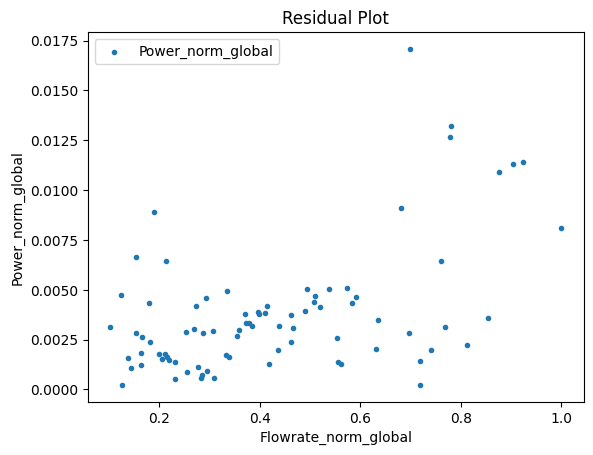

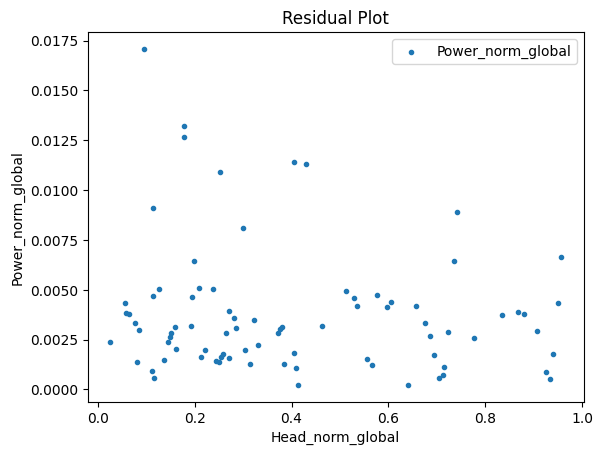

[<Figure size 640x480 with 1 Axes>, <Figure size 640x480 with 1 Axes>]

In [41]:
# visualize with IDAES surrogate plotting tools for validation data
surrogate_scatter2D(
    poly_surr, data_validation, filename="pysmo_poly_val_multispeed_catter2D.pdf"
)
surrogate_parity(
    poly_surr, data_validation, filename="pysmo_poly_val_multispeedparity.pdf"
)
surrogate_residual(
    poly_surr, data_validation, filename="pysmo_poly_val_multispeedresidual.pdf"
)

In [42]:
# Display metrics for the trained surrogate
metrics_df = display_surrogate_metrics("pysmo_poly_surrogate_multispeed.json")

Surrogate Model Error Metrics: pysmo_poly_surrogate_multispeed.json


,Output Variable,MAE,MSE,R2,Adjusted R2
0,Power_norm_global,0.003345,0.000022,0.999739,0.99973


## Build pump model with PySMO surrogate for multi-speed pump

In [43]:
# Build pump model
m = ConcreteModel()
m.fs = FlowsheetBlock(dynamic=False)

m.fs.props = SeawaterParameterBlock()

m.fs.pump = Pump(
    property_package=m.fs.props,
)
# Fix inlet conditions
m.fs.pump.control_volume.properties_in[0].pressure.fix(101325)  # Pa
m.fs.pump.control_volume.properties_in[0].temperature.fix(298.15)  # K

m.fs.pump.control_volume.properties_in[0].flow_mass_phase_comp["Liq", "TDS"].fix(
    0.1
)  # kg/s
m.fs.pump.control_volume.properties_in[0].flow_vol_phase["Liq"].fix(
    10 * pyunits.gallon / pyunits.min
)
print("Degrees of freedom =", degrees_of_freedom(m))

Degrees of freedom = 2


### Normalized Variables and Linking Constraints

We create normalized variables that match the surrogate model's inputs/outputs, then link them to the actual pump model variables.

**Normalized Variables:**

| Variable | Description | 
|----------|-------------|
| $\tilde{Q}$ | Normalized flow rate |
| $\tilde{H}$ | Normalized head |
| $\tilde{P}$ | Normalized power |

**Linking Constraints:**

$$\tilde{Q} = \frac{Q}{Q_{max}}$$

$$\tilde{H} = \frac{\Delta P}{\rho \cdot g \cdot H_{max}}$$

$$\tilde{P} = \frac{W}{P_{max}}$$

where:
- $Q$ is the volumetric flow rate
- $\Delta P$ is the pressure rise across the pump
- $\rho$ is the fluid density
- $g$ is gravitational acceleration
- $W$ is the mechanical work (power consumption)
- $Q_{max}$, $H_{max}$, $P_{max}$ are the maximum values from the pump curve data

In [44]:
# Define normalized input and output variables and constraints to link to actual pump model variables
Qmax = full_data["Flowrate_GPM"].max()

m.fs.normalized_flow_vol_in = Var(
    [0],
    initialize=0.5,
)
m.fs.eq_pump_flow = Constraint(
    expr=1
    == m.fs.pump.control_volume.properties_in[0].flow_vol_phase["Liq"]
    / pyunits.convert(
        m.fs.normalized_flow_vol_in[0] * Qmax * pyunits.gallon / pyunits.min,
        to_units=pyunits.m**3 / pyunits.s,
    )
)

Hmax = full_data["Head_ft"].max()
m.fs.normalized_head = Var(
    [0],
    initialize=0.5,
)
m.fs.eq_pump_head = Constraint(
    expr=1
    == m.fs.pump.control_volume.deltaP[0]
    / (
        pyunits.convert(
            m.fs.normalized_head[0] * Hmax * pyunits.feet, to_units=pyunits.m
        )
        * m.fs.pump.control_volume.properties_in[0].dens_mass_phase["Liq"]
        * C.acceleration_gravity
    )
)

Pmax = full_data["Power_HP"].max()
m.fs.normalized_power_consumption = Var(
    [0],
    initialize=0.5,
)
m.fs.eq_pump_power = Constraint(
    expr=1
    == m.fs.pump.work_mechanical[0]
    / pyunits.convert(
        m.fs.normalized_power_consumption[0] * Pmax * pyunits.hp, to_units=pyunits.W
    )
)

## **Try it yourself #2:** Integrate the multi-speed PySMO surrogate we just created with the WaterTAP pump model.

<details>
  <summary><b>&#128161;Hint</b>: Build the surrogate block</summary>
    
```python
inputs = [
    m.fs.normalized_flow_vol_in,
    m.fs.normalized_head,
]
outputs = [
    m.fs.normalized_power_consumption,
]

# create the Pyomo/IDAES block that corresponds to the surrogate
surrogate = PysmoSurrogate.load_from_file("pysmo_poly_surrogate_multispeed.json")
m.fs.surrogate = SurrogateBlock(concrete=True)
m.fs.surrogate.build_model(surrogate, input_vars=inputs, output_vars=outputs)
```
</details>

In [45]:
# Define inputs (normalized flowrate and normalized head) and outputs (normalized power consumption) for the surrogate block
# inputs = ...
# outputs = ...

# Load the surrogate and build the surrogate block
# surrogate = ...
# m.fs.surrogate = ...
# m.fs.surrogate.build_model(...)

In [46]:
inputs = [
    m.fs.normalized_flow_vol_in,
    m.fs.normalized_head,

]
outputs = [
    m.fs.normalized_power_consumption,
]

# create the Pyomo/IDAES block that corresponds to the surrogate
surrogate = PysmoSurrogate.load_from_file("pysmo_poly_surrogate_multispeed.json")
m.fs.surrogate = SurrogateBlock(concrete=True)
m.fs.surrogate.build_model(surrogate, input_vars=inputs, output_vars=outputs)

2026-01-23 12:20:11 [INFO] idaes.core.surrogate.pysmo_surrogate: Decode surrogate. type=poly

===========================Polynomial Regression===============================================


The number of cross-validation cases (3) is used.
The default training/cross-validation split of 0.75 is used.
No iterations will be run.
Default parameter estimation method is used.
Parameter estimation method:  pyomo 



In [47]:
# solve flowsheet

# Calculate surrogate output based on fixed inputs to initialize the surrogate

calculate_variable_from_constraint(
    m.fs.normalized_power_consumption[0],
    m.fs.surrogate.pysmo_constraint["Power_norm_global"],
)

iscale.calculate_scaling_factors(m)
# m.fs.pump.initialize()
print("DOF=", degrees_of_freedom(m))
solver = get_solver()

m.fs.pump.work_mechanical[0].setlb(0)
m.fs.pump.work_mechanical[0].setub(3.3*pyunits.hp)

m.fs.pump.efficiency_pump[0].setlb(0)
m.fs.pump.efficiency_pump[0].setub(0.53)

solver.solve(m.fs.pump.control_volume.properties_in[0], tee=True)
results = solver.solve(m, tee=True)
assert_optimal_termination(results)

2026-01-23 12:20:11 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.pump.control_volume.properties_in[0.0].flow_mass_phase_comp[Liq,H2O]
2026-01-23 12:20:11 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.pump.control_volume.properties_in[0.0].flow_mass_phase_comp[Liq,TDS]
2026-01-23 12:20:11 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.pump.control_volume.properties_out[0.0].flow_mass_phase_comp[Liq,H2O]
2026-01-23 12:20:11 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.pump.control_volume.properties_out[0.0].flow_mass_phase_comp[Liq,TDS]
2026-01-23 12:20:11 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.pump.control_volume.work
DOF= 1
ipopt-watertap: ipopt with user variable scaling and IDAES jacobian constraint scaling
Ipopt 3.13.2: tol=1e-08
constr_viol_tol=1e-08
acceptable_constr_viol_tol=1e-08
bound_relax_factor=0.0
honor_original_bounds=no
nlp_scaling_method=user-scaling


*****************

In [48]:
sweep_params = {}
# Define the parameter sweep for the pump flow rate
sweep_params["Flowrate"] = LinearSample(
    m.fs.pump.control_volume.properties_in[0].flow_vol_phase,
    value(
        pyunits.convert(
            1 * pyunits.gallon / pyunits.min, to_units=pyunits.m**3 / pyunits.s
        )
    ),
    value(
        pyunits.convert(
            15 * pyunits.gallon / pyunits.min, to_units=pyunits.m**3 / pyunits.s
        )
    ),
    11,
)
sweep_params["Normalized Head"] = LinearSample(
    m.fs.normalized_head,
    xmin["Head_norm_global"],
    xmax["Head_norm_global"],
    11,
)
outputs = {}
outputs["Efficiency"] = m.fs.pump.efficiency_pump[0]
outputs["Power Consumption_W"] = m.fs.pump.work_mechanical[0]
outputs["Pressure"] = m.fs.pump.deltaP[0]

# Perform the parameter sweep
file_save = "multispeed_pump_surrogate_sensitivity.csv"

results_array, results_dict = parameter_sweep(
    build_model=m,
    build_sweep_params=sweep_params,
    build_outputs=outputs,
    csv_results_file_name=file_save,
    interpolate_nan_outputs=True,
)

c:\Users\Adam\.conda\envs\watertap-academy\Lib\site-packages\pyomo\core\expr\numeric_expr.py:1149: RuntimeWarning: divide by zero encountered in scalar divide
  return result[0] / result[1]


model.name="unknown";
    - termination condition: infeasible
    - message from solver: Ipopt 3.13.2\x3a Converged to a locally infeasible
      point. Problem may be infeasible.
model.name="unknown";
    - termination condition: infeasible
    - message from solver: Ipopt 3.13.2\x3a Converged to a locally infeasible
      point. Problem may be infeasible.
model.name="unknown";
    - termination condition: infeasible
    - message from solver: Ipopt 3.13.2\x3a Converged to a locally infeasible
      point. Problem may be infeasible.
model.name="unknown";
    - termination condition: infeasible
    - message from solver: Ipopt 3.13.2\x3a Converged to a locally infeasible
      point. Problem may be infeasible.
model.name="unknown";
    - termination condition: infeasible
    - message from solver: Ipopt 3.13.2\x3a Converged to a locally infeasible
      point. Problem may be infeasible.
model.name="unknown";
    - termination condition: infeasible
    - message from solver: Ipopt 3.13.

In [49]:
# Load the results
df = pd.read_csv(file_save)
sweepsize=len(df)
df = df.dropna()  # Remove any rows with NaN values
print(f"Valid solutions: {len(df)} out of {sweepsize}")
df

Valid solutions: 52 out of 121


,# Flowrate,Normalized Head,Efficiency,Power Consumption_W,Pressure
15,0.000151,0.38180,0.425372,429.4147,1206347.0
16,0.000151,0.47725,0.368078,620.3200,1507934.0
17,0.000151,0.57270,0.330039,830.1779,1809521.0
18,0.000151,0.66815,0.301865,1058.9380,2111108.0
19,0.000151,0.76360,0.280564,1302.0970,2412694.0
20,0.000151,0.85905,0.265478,1548.1000,2714281.0
21,0.000151,0.95450,0.257163,1775.7320,3015868.0
26,0.000240,0.38180,0.517973,511.5430,1105207.0
27,0.000240,0.47725,0.464273,713.3879,1381508.0
28,0.000240,0.57270,0.425449,934.1853,1657810.0


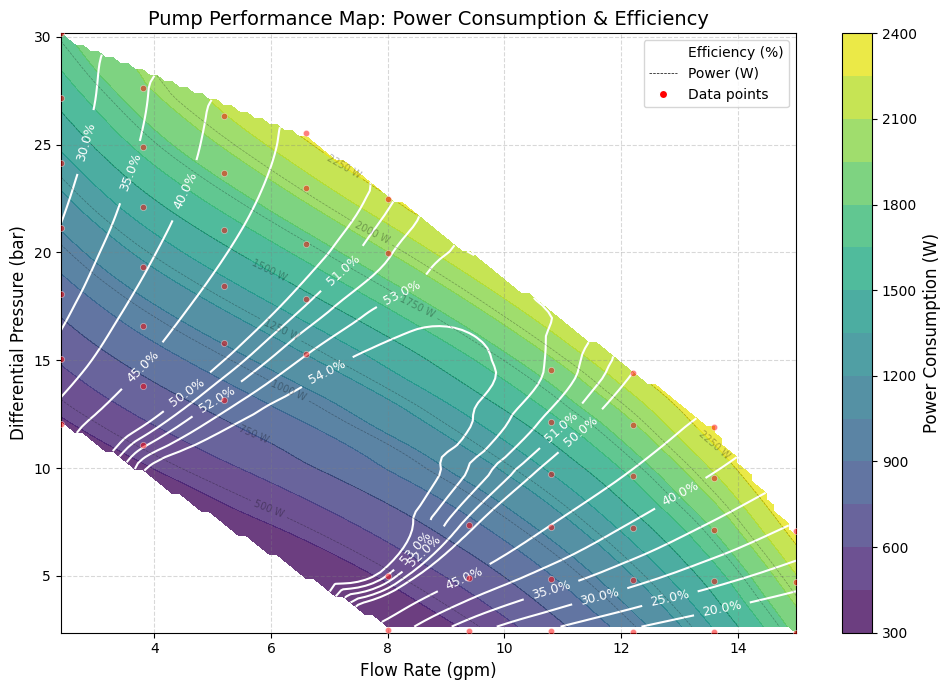


=== Operating Range ===
Flow: 2.4 - 15.0 gpm
Pressure: 2.37 - 30.16 bar
Power: 293.8 - 2351.6 W
Efficiency: 12.3 - 52.9 %

Max efficiency: 52.9% at 6.6 gpm, 15.31 bar


In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata
from matplotlib.lines import Line2D

# Convert units
df['Flowrate_gpm'] = df['# Flowrate'] * 15850.323  # m3/s to US gal/min
df['Pressure_bar'] = df['Pressure'] / 1e5

# Extract data points
x = df['Flowrate_gpm'].values
y = df['Pressure_bar'].values
z_power = df['Power Consumption_W'].values
z_efficiency = df['Efficiency'].values * 100

# Create regular grid for interpolation
xi = np.linspace(x.min(), x.max(), 100)
yi = np.linspace(y.min(), y.max(), 100)
Xi, Yi = np.meshgrid(xi, yi)

# Interpolate onto regular grid
Z_power = griddata((x, y), z_power, (Xi, Yi), method='cubic')
Z_efficiency = griddata((x, y), z_efficiency, (Xi, Yi), method='cubic')

# Cap efficiency at 53% for display
Z_efficiency_capped = np.clip(Z_efficiency, None, 55)

# Create contour plot
fig, ax = plt.subplots(figsize=(10, 7))

# Power consumption as filled contours (background)
contourf = ax.contourf(Xi, Yi, Z_power, levels=15, cmap='viridis', alpha=0.8)

# Efficiency as line contours (overlay) - levels up to 53%
eff_levels = [20, 25, 30, 35, 40, 45, 50, 51, 52, 53, 54, 55]
contour_eff = ax.contour(Xi, Yi, Z_efficiency_capped, levels=eff_levels, colors='white', 
                         linewidths=1.5, linestyles='solid')
ax.clabel(contour_eff, inline=True, fontsize=9, fmt='%0.1f%%', 
          inline_spacing=10)

# Power consumption line contours (optional, lighter)
contour_power = ax.contour(Xi, Yi, Z_power, levels=8, colors='black', 
                           linewidths=0.5, alpha=0.3, linestyles='dashed')
ax.clabel(contour_power, inline=True, fontsize=7, fmt='%0.0f W')

# Overlay actual data points
ax.scatter(x, y, c='red', s=20, alpha=0.5, edgecolors='white', 
          linewidths=0.5, zorder=10, label='Data points')

# Colorbar for power
cbar = plt.colorbar(contourf, ax=ax)
cbar.set_label('Power Consumption (W)', fontsize=12)

# Labels and title
ax.set_xlabel('Flow Rate (gpm)', fontsize=12)
ax.set_ylabel('Differential Pressure (bar)', fontsize=12)
ax.set_title('Pump Performance Map: Power Consumption & Efficiency', fontsize=14)

# Grid
ax.grid(True, alpha=0.3, linestyle='--', color='gray')

# Legend
legend_elements = [
    Line2D([0], [0], color='white', linewidth=1.5, label='Efficiency (%)'),
    Line2D([0], [0], color='black', linewidth=0.5, linestyle='--', label='Power (W)'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', 
           markersize=6, label='Data points', linestyle='None')
]
ax.legend(handles=legend_elements, loc='upper right', fontsize=10)

plt.tight_layout()
plt.show()

# Print summary
print("\n=== Operating Range ===")
print(f"Flow: {x.min():.1f} - {x.max():.1f} gpm")
print(f"Pressure: {y.min():.2f} - {y.max():.2f} bar")
print(f"Power: {z_power.min():.1f} - {z_power.max():.1f} W")
print(f"Efficiency: {z_efficiency.min():.1f} - {z_efficiency.max():.1f} %")
print(f"\nMax efficiency: {z_efficiency.max():.1f}% at {x[z_efficiency.argmax()]:.1f} gpm, {y[z_efficiency.argmax()]:.2f} bar")

